# Standard Gaussian Hidden Markov Model

This notebook goes through the basic steps to train and inspect a standard Gaussian Hidden Markov Model (HMM). This model is fit to a single set of timeseries, such as neuroimaging or electrophysiological recordings. If you want to model two sets of timeseries and their interaction, the toolbox also offers the [*Gaussian-Linear HMM*](./GLHMM_example.ipynb).

## Background
The HMM is a generative probabilistic model that assumes that an observed timeseries (e.g., neuroimaging or electrophysiological recordings) were generated by a sequence of hidden "states". In the Gaussian HMM, we model states as Gaussian distributions, so we assume that the observations *Y* at time point *t* were generated by a Gaussian distribution with parameters $\mu$ and $\Sigma$ when state *k* is active, i.e.:
$$Y_t\sim N(\mu^k,\Sigma^k)$$

Additionally, the HMM estimates the probabilities $\theta$ of transitioning between each pair of states, i.e., the probability that the currently active state at time point *t* is *k* given that the state at the previous timepoint *t-1* was *l*:
$$P(s_t=k|s_{t-1}=l) = \theta_{k,l}$$

And the probability $\pi$ that a segment of the timeseries starts with state *k*:
$$P(s_0=k)=\pi_k$$

When we fit the model to the observations, we  aim to estimate the parameters of the prior distributions for these parameters ($\mu$, $\Sigma$, $\theta$, and $\pi$) using variational inference. 

We define the posterior estimates as 
$$\gamma_{t,k}:=P(s_t=k|s_{>t},s_{<t}, Y)$$
$$\xi_{t,k,l}:=P(s_t=k,s_{t-1}=l|s_{>t},s_{<t-1},Y)$$

where $\gamma$ are the probabilities of state *k* being active at time point *t* (the state time courses) and $\xi$ are the joint state probabilities. 
Instead of the state time courses, we can also use the Viterbi path, a discrete representation of which state is active at each time point.

A common application for the standard Gaussian HMM is the estimation of time-varying amplitude and functional connectivity in fMRI recordings (e.g., [Vidaurre et al., 2017](https://www.pnas.org/doi/10.1073/pnas.1705120114)). 


## Example: Standard Gaussian HMM on synthetic timeseries

We will now go through an example illustrating how to fit and inspect a standard Gaussian HMM. The example uses simulated data that can be found in the `example_data` folder. The data were generated to resemble fMRI timeseries, and our goal is to estimate time-varying amplitude and functional connectivity (FC) for a group of subjects. Imagine that the data were recorded from 20 different subjects. Each subject has been recorded for 1,000 timepoints and their timeseries were extracted in a parcellation with 50 brain regions. The data *Y* here thus has dimensions ((20 subjects * 1000 timepoints), 50 brain regions). We use the *indices* array to specify where in the timeseries each of the 20 subjects' session starts and ends.

### Preparation
If you have not done so, install the repo using:

In [ ]:
pip install glhmm

We then need to import the relevant modules:

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import glhmm.glhmm as glhmm
from glhmm import preproc, utils

### Load data
The Gaussian HMM requires only one input: a timeseries `Y`. When running the model on a concatenated timeseries, e.g., a group of subjects or several scanning sessions, you also need to provide the `indices` indicating where each subject/session in the concatenated timeseries `Y` starts and ends.

Input data for the glhmm should be in numpy format. Other data types, such as .csv, can be converted to numpy using e.g. pandas, as shown below. Alternatively, the `io` module provides useful functions to load input data in the required format, e.g., from existing .mat-files. If you need to create indices from session lengths (as used in the HMM-MAR toolbox) you can use the `auxiliary.make_indices_from_T` function. 

Synthetic data for this example are provided as example in the `glhmm/docs/notebooks/example_data` folder. The file `data.csv` contains synthetic timeseries. The data should have the shape ((no subjects/sessions * no timepoints), no features), meaning that all subjects and/or sessions have been concatenated along the first dimension. The second dimension is the number of features, e.g., the number of parcels or channels. The file `T.csv` specifies the indices in the concatenated timeseries corresponding to the beginning and end of individual subjects/sessions in the shape (no subjects, 2). In this case, we have generated timeseries for 20 subjects and 50 features. Each subject has 1,000 timepoints. The timeseries has the shape (20000, 50) and the indices have the shape (20, 2).

In [3]:
data_tmp = pd.read_csv('./example_data/data.csv', header=None)
T_t_tmp = pd.read_csv('./example_data/T.csv', header=None)
data = data_tmp.to_numpy()
T_t = T_t_tmp.to_numpy()

**NOTE: It is important to standardise your timeseries and, if necessary, apply other kinds of preprocessing before fitting the model.** The data provided here are already standardised (so the code below will not do anything), but see [Prediction tutorial](./Prediction_example.ipynb) for an example using real data. 

In [4]:
data,_ = preproc.preprocess_data(data, T_t)

### Initialise and train HMM
We first initialise the hmm object and specify hyperparameters. In the case of the standard Gaussian HMM, since we do not want to model an interaction between two sets of variables, we set `model_beta='no'`. The number of states is specified using the `K` parameter. We here estimate `K=4` states. If you want to model a different number of states, change K to a different value. In this example, we want to model states as Gaussian distributions with a mean and full covariance matrix, so that each state is described by a mean amplitude and functional connectivity pattern. To do this, specify `covtype='full'`, the state-specific mean is already set by default. If you do not want to model the mean, add `model_mean='no'`. 

In [5]:
hmm = glhmm.glhmm(model_beta='no', K=4, covtype='full')

Optionally, you can check the hyperparameters (including the ones set by default) to make sure that they correspond to how you want the model to be set up.

In [6]:
print(hmm.hyperparameters)

{'K': 4, 'covtype': 'full', 'model_mean': 'state', 'model_beta': 'no', 'dirichlet_diag': 10, 'connectivity': None, 'Pstructure': array([[ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True],
       [ True,  True,  True,  True]]), 'Pistructure': array([ True,  True,  True,  True])}


We then train the HMM using the data and indices loaded above. Since we here do not model an interaction between two sets of timeseries but run a standard HMM instead, we set `X=None`. `Y` should be the timeseries in which we want to estimate states (in here called `data`) and indices should be the beginning and end indices of each subject (here called `T_t`). During training, the output will show the progress in model fit at each iteration.

In [ ]:
hmm.train(X=None, Y=data, indices=T_t)

Optionally, you can also return `Gamma` (the state probabilities at each timepoint), `Xi` (the joint probabilities of past and future states conditioned on the data) and `FE` (the free energy of each iteration) at this step, but it is also possible to retrieve them later using the `decode` function for Gamma and Xi and the `get_fe` function for the free energy. 

In [ ]:
Gamma,Xi,FE = hmm.train(X=None, Y=data, indices=T_t)

### Inspect model
We then inspect some interesting aspects of the model: the transition probabilities, the state means, and the state covariances.

In [9]:
K = hmm.hyperparameters["K"] # the number of states
q = data.shape[1] # the number of parcels/channels
TP = np.zeros(shape=(K, K))
TP = hmm.P # the transition probability matrix
state_means = np.zeros(shape=(q, K))
state_means = hmm.get_means() # the state means in the shape (no. features, no. states)
state_FC = np.zeros(shape=(q, q, K))
for k in range(K):
    state_FC[:,:,k] = hmm.get_covariance_matrix(k=k) # the state covariance matrices in the shape (no. features, no. features, no. states)

#### Plot results

> For more plotting options, refer to the functions in the module called [Graphics](../../glhmm/graphics.py)

Plot transition probability matrix. Note that self-transitions (i.e., staying in the same state) are considerably more likely in a timeseries that has some order, so there should be a strong diagonal pattern

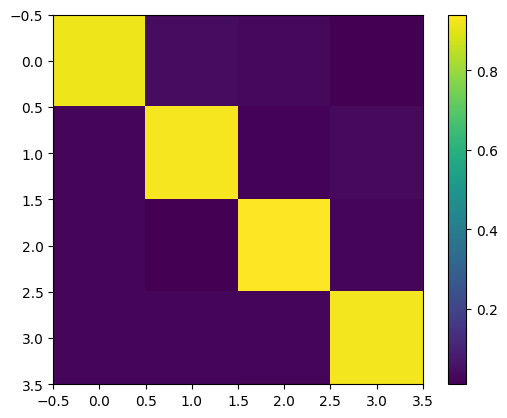

In [10]:
plt.imshow(TP)
plt.colorbar()
plt.show()

Plot the state means. This will show the states on the x-axis, each parcel/channel on the y-axis, and the mean activation of each parcel in each state as the color intensity.

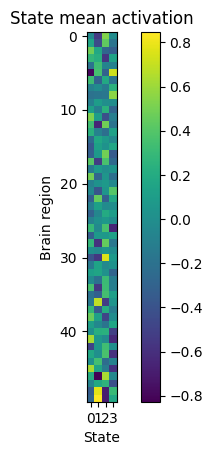

In [11]:
plt.imshow(state_means)
plt.colorbar()
plt.title("State mean activation")
plt.xticks(np.arange(4))
plt.gca().set_xlabel('State')
plt.gca().set_ylabel('Brain region')
plt.show()

Plot the covariance matrices (i.e. FC) of all states. 

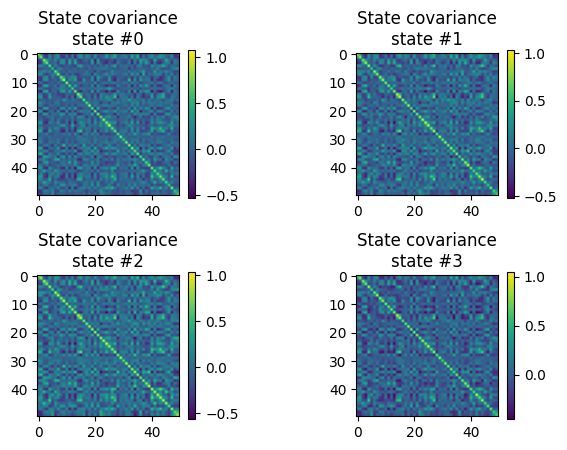

In [12]:
for k in range(4):
    plt.subplot(2,2,k+1)
    plt.imshow(state_FC[:,:,k])
    plt.colorbar()
    plt.title("State covariance\nstate #%s" % (k))
plt.subplots_adjust(hspace=0.5, wspace=0.8)
plt.show()

#### Viterbi path
The Viterbi path is a discrete representation of the state timecourse, indicating which state is active at which timepoint. This can be informative, e.g., to understand whether the HMM is "mixing", i.e., states occur across subjects, or whether the model estimates the entire session of one subject as one state (see [Ahrends et al. 2022](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9361391/)).
You can retrieve the Viterbi path using the `decode` function and setting `viterbi=True`:

In [13]:
vpath = hmm.decode(X=None, Y=data, indices=T_t, viterbi=True)

And plot the Viterbi path (see also `graphics` module):

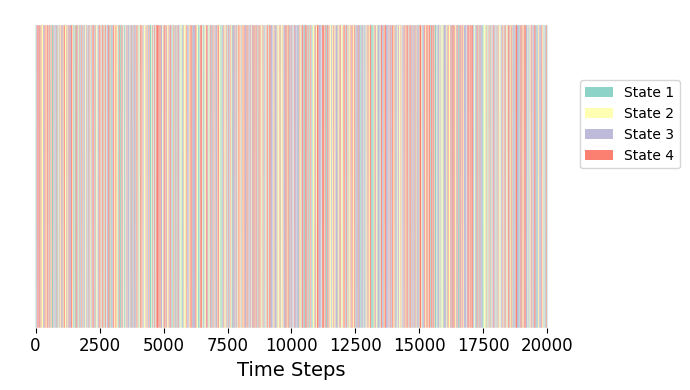

In [20]:
signal =[]
xlabel = "Time Steps"
figsize=(7, 4)
ylabel = ""
yticks=None
line_width=2
label_signal="Signal"

num_states = vpath.shape[1]

# Create a Seaborn color palette
colors = sb.color_palette("Set3", n_colors=num_states)

# Plot the stack plot using Seaborn
fig, axes = plt.subplots(figsize=figsize)  # Adjust the figure size for better readability
axes.stackplot(np.arange(vpath.shape[0]), vpath.T, colors=colors, labels=[f'State {i + 1}' for i in range(num_states)])

# Set labels and legend to the right of the figure
axes.set_xlabel(xlabel, fontsize=14)
axes.set_ylabel(ylabel, fontsize=14)
axes.legend(title='States', loc='upper left', bbox_to_anchor=(1, 1))  # Adjusted legend position

# Remove x-axis tick labels
axes.set_yticks([])

# Remove the frame around the plot
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_visible(False)
axes.spines['left'].set_visible(False)

axes.legend(loc='upper left', bbox_to_anchor=(1, 0.8))  # Adjusted legend position

# Increase tick label font size
axes.tick_params(axis='both', labelsize=12)
plt.tight_layout() 
# Show the plot
plt.show()

Plotting the Viterbi path indicates that the states show fast dynamics across all subjects (concatenated along the y-axis).

#### Summary metrics
Once we have estimated the model parameters, we can compute some summary metrics to describe the patterns we see more broadly. These summary metrics can be useful to relate patterns in the timeseries to behaviour, using e.g., statistical testing (see [Statistical testing tutorial](./1_across_subjects_test.ipynb)) or machine learning (see [Prediction tutorial](./Prediction_example.ipynb)). The module `utils` provides useful functions to obtain these summary metrics.

The *fractional occupancy (FO)* indicates the fraction of time in each session that is occupied by each state. For instance, if one state was active for the entire duration of the session, this state's FO would be 1 (100%) and all others would be 0. If, on the other hand, all states are present for an equal amount of timepoints in total, the FO of all states would be 1/*K* (the number of states). This can be informative to understand whether one state is more present in a certain group of subjects or experimental condition, or to interrogate mixing (explained above).

You can obtain the fractional occupancies using the `get_FO` function. The output is an array containing the FO of each subject along the first dimension and each state along the second dimension. 

Fractional occupancies, switching rates, lifetimes

In [22]:
FO = utils.get_FO(Gamma, indices=T_t)
print(FO)

[[0.20013169 0.27565448 0.25012572 0.2740881 ]
 [0.28041115 0.21759851 0.25141496 0.25057538]
 [0.24500913 0.24710203 0.2681099  0.23977895]
 [0.24454097 0.24839839 0.29378891 0.21327174]
 [0.20186346 0.28623125 0.25109077 0.26081451]
 [0.23954156 0.28807142 0.27225456 0.20013247]
 [0.24215762 0.24400319 0.25483735 0.25900185]
 [0.21482612 0.27995298 0.30377624 0.20144465]
 [0.20019    0.26003207 0.26768594 0.27209199]
 [0.19104896 0.28516887 0.27321619 0.25056598]
 [0.24136582 0.24326982 0.29200308 0.22336129]
 [0.18612955 0.25832649 0.27303241 0.28251155]
 [0.20837596 0.27923861 0.2971211  0.21526433]
 [0.21394188 0.22893883 0.2986742  0.25844508]
 [0.21382826 0.25285501 0.30332096 0.22999577]
 [0.23915589 0.24884193 0.23271725 0.27928493]
 [0.18344956 0.22854902 0.28564526 0.30235617]
 [0.28036488 0.25203982 0.29381529 0.17378001]
 [0.22697445 0.22218814 0.2960367  0.25480071]
 [0.23261249 0.24292069 0.31529367 0.20917315]]


The switching rate indicates how quickly subjects switch between states (as opposed to stay in the same state).

In [23]:
SR = utils.get_switching_rate(Gamma, T_t)
print(SR)

[[0.03409521 0.03729453 0.03860144 0.04753713]
 [0.04257329 0.0441751  0.03024138 0.04598377]
 [0.03518411 0.03777353 0.0275691  0.03593348]
 [0.03436448 0.03984698 0.03940116 0.03186797]
 [0.03144759 0.02946411 0.02882615 0.02927245]
 [0.04789287 0.0384118  0.03904816 0.03084386]
 [0.03055078 0.03117567 0.0245296  0.0261066 ]
 [0.03593128 0.04750526 0.03506351 0.03963236]
 [0.03458658 0.03788474 0.03192681 0.03566017]
 [0.03471736 0.03214439 0.0295627  0.03926983]
 [0.0425638  0.03380191 0.03225398 0.03080603]
 [0.04105975 0.04292449 0.03453453 0.03537252]
 [0.03975854 0.03783184 0.03295046 0.0386734 ]
 [0.02618851 0.03303499 0.02870096 0.0349791 ]
 [0.03518327 0.03622382 0.03764476 0.04140415]
 [0.03721607 0.04336131 0.02548445 0.04063043]
 [0.03511719 0.02960685 0.03207903 0.04014642]
 [0.03575977 0.03198141 0.03077724 0.03046555]
 [0.03630331 0.03510132 0.03084258 0.0337883 ]
 [0.03745095 0.03622905 0.0444259  0.03601068]]


The state lifetimes indicate how long a state is active at a time (either on average, median, or maximum). This can be informative to understand whether states tend to last longer or shorter times, pointing towards slower vs. faster dynamics:

In [24]:
LTmean, LTmed, LTmax = utils.get_life_times(vpath, T_t)
print(LTmean)

[[11.82352941 15.11111111 13.26315789 11.45833333]
 [13.9        10.33333333 16.8        11.5       ]
 [14.41176471 13.61111111 19.57142857 13.88235294]
 [14.58823529 13.10526316 14.5        14.2       ]
 [12.5        20.64285714 18.         18.5       ]
 [ 9.68       16.22222222 14.21052632 14.        ]
 [16.92857143 15.4375     21.41666667 21.58333333]
 [12.11111111 12.68181818 16.94444444 10.42105263]
 [11.76470588 13.94736842 17.86666667 16.6875    ]
 [11.6875     17.9375     18.6        13.        ]
 [11.42857143 14.52941176 19.53333333 14.66666667]
 [ 9.63157895 11.68181818 16.35294118 15.66666667]
 [10.94736842 14.31578947 18.6875     11.63157895]
 [17.75       13.41176471 21.21428571 15.41176471]
 [12.58823529 14.11111111 16.77777778 10.95238095]
 [13.22222222 11.31818182 17.92307692 14.        ]
 [10.64705882 16.35714286 17.8125     14.52380952]
 [16.47058824 15.5        18.375      11.86666667]
 [12.66666667 13.875      19.66666667 15.9375    ]
 [12.26315789 13.10526316 14.13